## Initial Setup

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [50]:
# Defaults
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 

# Preprocessing & Asessment
from sklearn import model_selection 
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import accuracy_score

# Models
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Saving
import pickle

In [2]:
# Setting option of displaying 
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_colwidth', 1000)
# Setting plotting options
sns.set_style('whitegrid')

In [3]:
# Paths to files with columns description, train and test data
paths = ['/Users/neteplo/Desktop/Study/Course_Work/data_HCB/home-credit-default-risk/HomeCredit_columns_description.csv',
        '/Users/neteplo/Desktop/Study/Course_Work/data_HCB/home-credit-default-risk/application_train.csv',
        '/Users/neteplo/Desktop/Study/Course_Work/data_HCB/home-credit-default-risk/application_test.csv']

In [4]:
# Creating DataFrame with column description
col_descr = pd.read_csv(paths[0],
                        encoding = "ISO-8859-1",
                        index_col = 0)

In [6]:
# Example of column description retrieving 
str(col_descr[col_descr['Row'] == 'TARGET']['Description'].values[0])

'Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)'

In [7]:
# Reading train and test data
train_data = pd.read_csv(paths[1], index_col='SK_ID_CURR')
test_data = pd.read_csv(paths[2], index_col='SK_ID_CURR')
train_data.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,N

## EDA

In [8]:
# Anomalies in days employed
print(train_data['DAYS_EMPLOYED'].describe())

train_data['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64


In [9]:
# First glance at train data
print('Train data shape: {}'.format(train_data.shape))
train_data.head()

Train data shape: (307511, 121)


,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637.0,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188.0,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225.0,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN

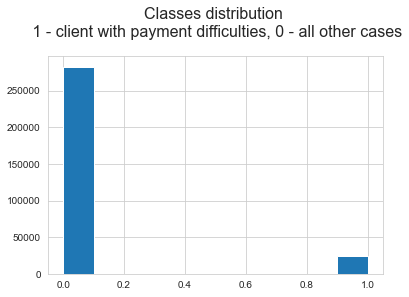

In [10]:
# Target value distribution
plt.hist(train_data['TARGET'])
plt.title('Classes distribution \n 1 - client with payment difficulties, 0 - all other cases', 
          fontsize = 16, 
          pad = 20)
plt.show()

In [11]:
frac = train_data['TARGET'].astype(bool).sum() / len(train_data['TARGET'])
print('Fraction of cases where client has problems with payments is: %.5f' % frac)

Fraction of cases where client has problems with payments is: 0.08073


#### !!!Very small fraction of Class 1 in the sample!!!
We have to take this fact into account while modeling
First path will be to stratification while splitting data into train and validation set. Second path to oversample 1st class in the sample (Model learning with second path's data cost more in terms of memory use)

#### Missing Values

In [12]:
def missing_values_table(df):
    
        '''Calculate percent of missing values 
         in each column of passed DataFrame'''
        
        # Total missing values
        mis_val = df.isna().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isna().sum() / len(df)

        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Пропущенных значений', 1 : '% от общего количества значений'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% от общего количества значений', ascending=False).round(1)
        
        # Print some summary information
        print ("DataFrame has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [13]:
missing_values_table(train_data)

DataFrame has 121 columns.
There are 68 columns that have missing values.


,Пропущенных значений,% от общего количества значений
COMMONAREA_MODE,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MEDI,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4
LIVINGAPARTMENTS_MODE,210199,68.4


As we can see, there are a lot of missing data. We must decide further what we will do with it: Replace somehow or drop it.

#### Correlation

<ipython-input-14-d2ab56d1311d>:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),


<AxesSubplot:>

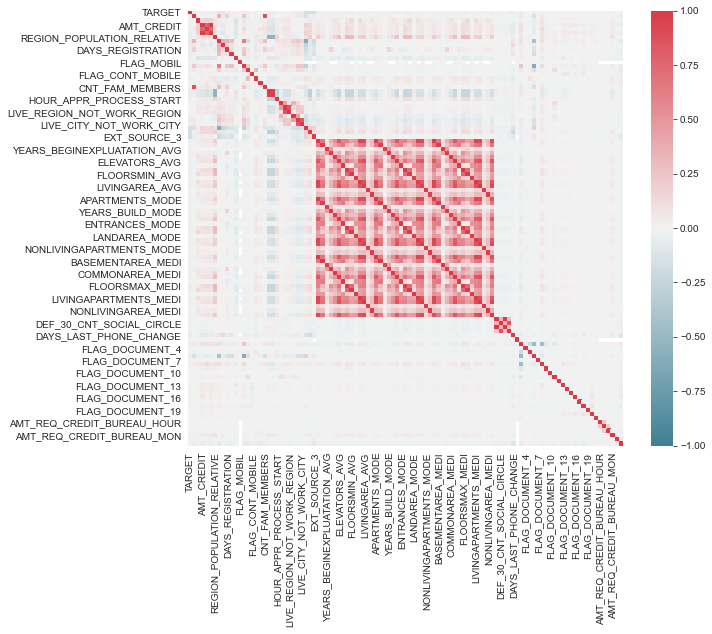

In [14]:
# Correlation matrix heatmap
f, ax = plt.subplots(figsize=(10, 8))
corr = train_data.corr()

sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            vmin = -1, square=True, ax=ax)

Ну тут надо получше отобразить, поближе посмотреть и разобраться поглубже

## Preprocessing

In [15]:
# Numerical data & Numerical data columns extraction
raw_num_data = train_data.select_dtypes(exclude = 'object').drop(['TARGET'], axis = 1)
raw_num_cols = raw_num_data.columns
raw_num_data.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100002,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637.0,-3648.0,-2120,NaN,1,1,0,1,1,0,1.0,2,2,10,0,0,0,0,0,0,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,0.0149,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
100003,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188.0,-1186.0,-291,NaN,1,1,0,1,1,0,2.0,1,1,11,0,0,0,0,0,0,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,0.0714,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
100004,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225.0,-4260.0,-2531,26.0,1,1,1,1,1,0,1.0,2,2,9,0,0,0,0,0,0,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
100006,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039.0,-9833.0,-2437,NaN,1,1,0,1,0,0,2.0,2,2,17,0,0,0,0,0,0,NaN,0.650442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
100007,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038.0,-4311.0,-3458,NaN,1,1,0,1,0,0,1.0,2,2,11,0,0,0,0,1,1,NaN,0.322738,NaN,NaN,NaN,Na

In [16]:
# Numerical data & Numerical data columns extraction
cat_data = train_data.select_dtypes(include = 'object')
cat_cols = cat_data.columns
cat_data.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
SK_ID_CURR,,,,,,,,,,,,,,,,
100002,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,reg oper account,block of flats,"Stone, brick",No
100003,Cash loans,F,N,N,Family,State servant,Higher education,Married,House / apartment,Core staff,MONDAY,School,reg oper account,block of flats,Block,No
100004,Revolving loans,M,Y,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,MONDAY,Government,NaN,NaN,NaN,NaN
100006,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,NaN,NaN,NaN,NaN
100007,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Core staff,THURSDAY,Religion,NaN,NaN,NaN,NaN


In [17]:
# Filtering pre-existed dummy variables from numerical data
ex_dum = pd.concat([raw_num_data.filter(regex=("FLAG.*")),
                    raw_num_data.filter(regex=("\wREGION")),
                    raw_num_data.filter(regex=("\wCITY"))],
                    axis = 1)

ex_dum_cols = ex_dum.columns

# Filtering ordinal data from numerical data
ex_cat = raw_num_data.select_dtypes(include = 'int')
ex_cat_cols = ex_cat.columns

# Categorical data to drop from numerical data
cols_to_drop = ex_dum_cols.append(ex_cat_cols)

# Dropping these columns
num_data = raw_num_data.drop(cols_to_drop, axis = 1)
num_cols = num_data.columns

In [18]:
# Categorical data description & unique values in each categorical column
for i in range(len(cat_cols)):
    print('{} has {} unique values'.format(cat_cols[i], cat_data[cat_cols[i]].nunique()))
    print(str(col_descr[col_descr['Row'] == cat_cols[i]]['Description'].values[0]), '\n')

NAME_CONTRACT_TYPE has 2 unique values
Identification if loan is cash or revolving 

CODE_GENDER has 3 unique values
Gender of the client 

FLAG_OWN_CAR has 2 unique values
Flag if the client owns a car 

FLAG_OWN_REALTY has 2 unique values
Flag if client owns a house or flat 

NAME_TYPE_SUITE has 7 unique values
Who was accompanying client when he was applying for the loan 

NAME_INCOME_TYPE has 8 unique values
Clients income type (businessman, working, maternity leave,) 

NAME_EDUCATION_TYPE has 5 unique values
Level of highest education the client achieved 

NAME_FAMILY_STATUS has 6 unique values
Family status of the client 

NAME_HOUSING_TYPE has 6 unique values
What is the housing situation of the client (renting, living with parents, ...) 

OCCUPATION_TYPE has 18 unique values
What kind of occupation does the client have 

WEEKDAY_APPR_PROCESS_START has 7 unique values
On which day of the week did the client apply for the loan 

ORGANIZATION_TYPE has 58 unique values
Type of org

In [20]:
# Filling missing values. 0 for numerical; no_info for categorical 
num_data = num_data.fillna(num_data.median()).copy()
cat_data = cat_data.fillna('NA').copy()

Categorical Data Encoding

In [21]:
# Transform categorical data into dummy variables
X_cat_dummy = pd.get_dummies(cat_data)

# Scaling numerical data
scaler = StandardScaler()
X_num_scaled = pd.DataFrame(scaler.fit_transform(num_data), 
                            columns = num_cols, 
                            index = train_data.index)

# Stacking categorical and numerical data
X = pd.concat([X_num_scaled,
               X_cat_dummy,
               ex_dum],
               axis = 1)

y = train_data['TARGET']

#### Data Splitting

In [22]:
# Train/validation splitting with stratification (y_train, y_test have the same shares of classes)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    random_state = 42,
                                                    stratify = y)

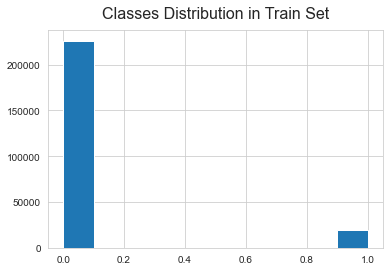

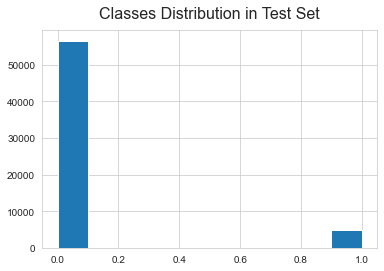

In [23]:
plt.hist(y_train)
plt.title('Classes Distribution in Train Set', fontsize = 16, pad = 12)
plt.show()
print('\n')
plt.hist(y_test)
plt.title('Classes Distribution in Test Set', fontsize = 16, pad = 12)
plt.show()

#### Oversampled set

In [24]:
# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy=0.5)
X_train_over, y_train_over = oversample.fit_resample(X_train, y_train)

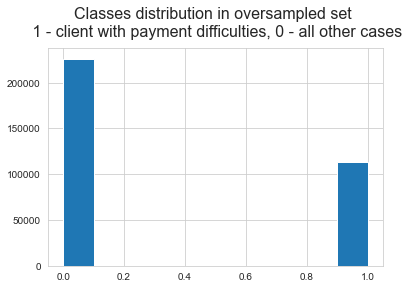

In [25]:
plt.hist(y_train_over)
plt.title('Classes distribution in oversampled set \n 1 - client with payment difficulties, 0 - all other cases', fontsize = 16, pad = 12)
plt.show()

## Modeling

##### LASSO LOGISTIC REGRESSION

In [26]:
# Logistic Regression with l1 regularization 
lasso_logit = LogisticRegression(solver= 'liblinear',
                                 penalty='l1',
                                 class_weight='balanced', 
                                 random_state=42)

lasso_logit.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', penalty='l1', random_state=42,
                   solver='liblinear')

0.748076530050443


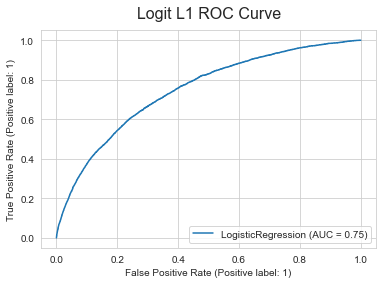

In [27]:
# ROC AUC score for logistic regression 
lasso_auc_os = roc_auc_score(y_test, lasso_logit.predict_proba(X_test)[:, 1])
print(lasso_auc_os)

# ROC plot
plot_roc_curve(lasso_logit, X_test, y_test, response_method='predict_proba')
plt.title('Logit L1 ROC Curve', fontsize = 16, pad = 12)
plt.show()

In [44]:
filename = 'lasso_logit.sav'
pickle.dump(lasso_logit, open(filename, 'wb'))

##### RIDGE LOGISTIC REGRESSION

In [28]:
# Logistic Regression with l2 regularization 
ridge_logit = LogisticRegression(penalty='l2',
                                 class_weight='balanced', 
                                 random_state=42)

ridge_logit.fit(X_train, y_train)

/Users/neteplo/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced', random_state=42)

0.7479741543594437


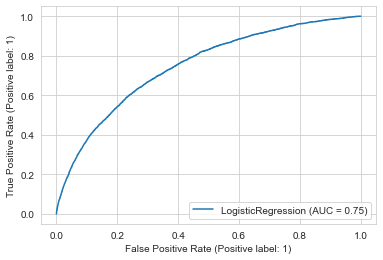

In [29]:
# ROC AUC score for logistic regression
ridge_auc = roc_auc_score(y_test, ridge_logit.predict_proba(X_test)[:, 1])
print(ridge_auc)

# ROC plot
plot_roc_curve(ridge_logit, X_test, y_test)
plt.show()

In [45]:
filename = 'ridge_logit.sav'
pickle.dump(ridge_logit, open(filename, 'wb'))

##### RANDOM FOREST CLF.

In [30]:
# Random Forest Clf.
rf = RandomForestClassifier(n_estimators = 200, 
                            verbose = 1, 
                            n_jobs = -1, 
                            random_state = 42)

rf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.2min finished


RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42, verbose=1)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


0.7138760331482356


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    1.1s finished


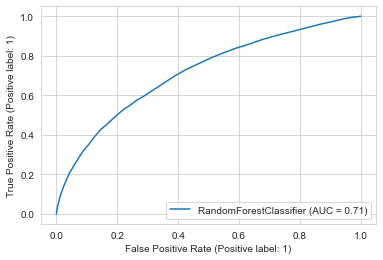

In [31]:
# ROC AUC score for RF clf.
rf_auc = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
print(rf_auc)

# ROC plot
plot_roc_curve(rf, X_test, y_test)
plt.show()

In [46]:
filename = 'rf.sav'
pickle.dump(rf, open(filename, 'wb'))

In [32]:
# Random Forest Clf. (Oversampled Data)
rf_os = RandomForestClassifier(n_estimators = 200, 
                               verbose = 1, 
                               n_jobs = -1, 
                               random_state = 42)

rf_os.fit(X_train_over, y_train_over)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.6min finished


RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42, verbose=1)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


0.7330089874941563


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    1.1s finished


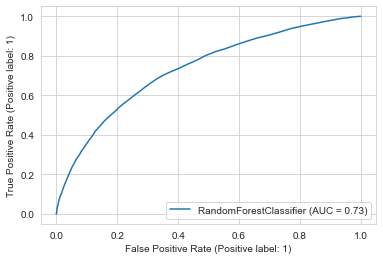

In [33]:
# ROC AUC score for RF clf. (Oversampled Data)
rf_auc_os = roc_auc_score(y_test, rf_os.predict_proba(X_test)[:, 1])
print(rf_auc_os)

# ROC plot
plot_roc_curve(rf_os, X_test, y_test)
plt.show()

In [47]:
filename = 'rf_os.sav'
pickle.dump(rf_os, open(filename, 'wb'))

As we can see, there is no significant boost in model quality using oversampled data 

##### GRADIENT BOOSTING CLF.

In [34]:
# Gradient Boosting Classifier 
xgb = XGBClassifier(use_label_encoder = False,
                    learning_rate = 0.15,
                    n_estimators = 700, 
                    max_depth = 20,
                    n_jobs = -1,
                    random_state = 42)

xgb.fit(X_train, y_train)

[16:03:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.15, max_delta_step=0, max_depth=20,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=700, n_jobs=-1, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

0.7270418166829629


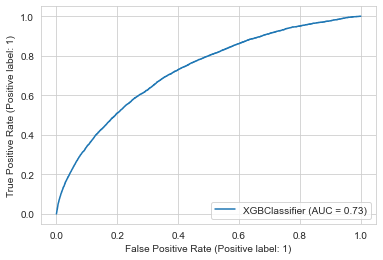

In [35]:
# ROC AUC score for gradient boosting clf.
xgb_auc = roc_auc_score(y_test, xgb.predict_proba(X_test)[:, 1])
print(xgb_auc)

# ROC plot
plot_roc_curve(xgb, X_test, y_test)
plt.show()

In [48]:
filename = 'xgb.sav'
pickle.dump(xgb, open(filename, 'wb'))

In [36]:
# Gradient Boosting Classifier (Oversampled Data)
xgb_os = XGBClassifier(use_label_encoder = False,
                       learning_rate = 0.15,
                       n_estimators = 700, 
                       max_depth = 10,
                       n_jobs = -1, 
                       random_state = 42)

xgb_os.fit(X_train_over, y_train_over)

[16:35:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.15, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=700, n_jobs=-1, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

0.7127849116228614


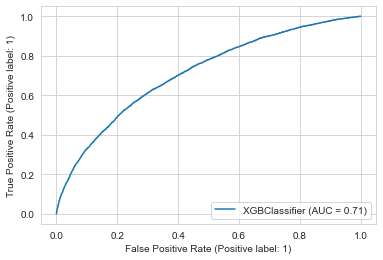

In [37]:
# ROC AUC score for gradient boosting clf. (Oversampled data)
xgb_auc_os = roc_auc_score(y_test, xgb_os.predict_proba(X_test)[:, 1])
print(xgb_auc_os)

# ROC plot
plot_roc_curve(xgb_os, X_test, y_test)
plt.show()

In [49]:
filename = 'xgb_os.sav'
pickle.dump(xgb_os, open(filename, 'wb'))

По бустингу и форесту: очень запаристые в плане настройки, надо прям потом будет посидеть подумать как их правильно настроить. 

#### LOADING MODELS
[Example](https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/)

In [43]:
loaded_model = pickle.load(open(filename, 'rb'))
lasso_auc_os = roc_auc_score(y_test, loaded_model.predict_proba(X_test)[:, 1])
print(lasso_auc_os)

0.748076530050443


#### GRID SEARCH FOR RANDOM FOREST CLF.

In [38]:
# RF Clf. setup
rf_clf_gcv = RandomForestClassifier(random_state=42)
# Available parameters to tune
rf_clf_gcv.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [39]:
# Dict. with parameters grid
parameters_grid_rf = {
    'n_estimators' : [500, 1000],
    'max_features' : [None, 'sqrt', 'log2'],
    'max_depth' : [None, 20, 50],
}

# Cross validation splitting rules (folders=5, size of validation set=20%)
cv = model_selection.StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)

# Grid cross-validation setup
grid_cv_rf = model_selection.GridSearchCV(rf_clf_gcv, parameters_grid_rf, scoring = 'roc_auc', cv = cv)

In [ ]:
# Grid search over parameters_grid with RF Clf.
grid_cv_rf.fit(X, y)

In [ ]:
print(grid_cv_rf.best_estimator_, '\n')
print(grid_cv_rf.best_score_, '\n')
print(grid_cv_rf.best_params_, '\n')
print(grid_cv_rf.cv_results_, '\n')

#### GRID SEARCH FOR GRADIENT BOOSTING CLF.

In [ ]:
# GB Clf. setup
xgb_gcv = XGBClassifier(n_estimators = 600, 
                        use_label_encoder = False, 
                        random_state = 42)

# Available parameters to tune
xgb_gcv.get_params().keys()

In [ ]:
parameters_grid_xgb = {
    'learning_rate' : [0.001, 0.01, 0.05, 0.1, 0.15, 0.2], #eta parameter
    'max_depth' : [3, 6, 10],
    'reg_alpha' : [0, 0.5, 1]
}

In [ ]:
# Grid cross-validation setup
grid_cv_xgb = model_selection.GridSearchCV(xgb_gcv, parameters_grid_xgb, scoring = 'roc_auc', cv = cv)

In [ ]:
# Grid search over parameters_grid with GB Clf.
grid_cv_xgb.fit(X, y)

In [ ]:
print(grid_cv_xgb.best_estimator_, '\n')
print(grid_cv_xgb.best_score_, '\n')
print(grid_cv_xgb.best_params_, '\n')
print(grid_cv_xgb.cv_results_, '\n')

In [86]:
lasso_logit.coef_

array([[ 1.40891628e-03,  8.98905255e-01,  1.10922923e-01,
        -9.52245039e-01,  2.18434084e-02,  1.48573504e-01,
         3.89711452e-02,  4.34356697e-02,  4.41330301e-03,
        -1.83064271e-01, -3.93706617e-01, -4.77727545e-01,
         1.29108748e-01, -3.98940325e-01,  1.19999811e-03,
         3.09568787e-01,  2.81925459e-02, -2.36600308e-02,
        -1.67487425e-01, -9.24795948e-02, -1.37856679e-03,
         5.31914172e-02, -1.02498931e-01,  2.91129306e-01,
        -7.68404715e-02,  7.76329259e-02,  7.42105125e-02,
         5.40106250e-04, -1.53450029e-02, -2.51851588e-02,
         1.13194575e-01,  6.86028203e-02, -6.09928209e-02,
         1.38406576e-03,  1.50615427e-03, -1.01965795e-02,
        -7.89853313e-02, -4.48722966e-02,  1.62726483e-01,
        -8.33128172e-02, -2.07369126e-01,  4.03246647e-01,
         1.48195075e-04, -2.91039932e-01, -1.41826589e-01,
        -5.40898225e-02,  1.92210981e-01,  4.97943339e-02,
         0.00000000e+00, -3.76796276e-02,  1.93964127e-0